# TABLE OF CONTENTS:
---
* [Workspace](#Workspace)
* [Data](#Data)
* [Compute Target](#Compute-Target)
* [Training Artifacts](#Training-Artifacts)
* [Development Environment](#Development-Environment)
* [Compute Target](#Compute-Target)
* [Development Environment](#Development-Environment)
* [Experiment & Run Configuration](#Experiment-&-Run-Configuration)
* [Model Registration](#Model-Registration)
* [Resource Clean Up](#Resource-Clean-Up)
---

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

In [2]:
import azureml.core
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Dataset, Environment, Experiment, Keyvault, Model, ScriptRunConfig, Workspace
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig 
from azureml.widgets import RunDetails

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.19.0


In [3]:
%load_ext autoreload
%autoreload 2

# Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the azureml SDK.

### Option 1: Create Workspace Object from Config

This option requires a config.json file containing the subscription id, resource group and workspace name. On an AML Compute Instance, this is available by default. For any other compute, the file can be downloaded from the workspace and put in the same directory as the calling file, a subdirectory named .azureml, or in a parent directory. Alternatively, the path can also be manually specified using the `path` argument.

<img src="../images/config_file.png" alt="config_file" width="600"/>

In [4]:
ws = Workspace.from_config() 
print("Workspace name: " + ws.name, 
      "Azure region: " + ws.location, 
      "Subscription id: " + ws.subscription_id, 
      "Resource group: " + ws.resource_group, sep="\n")

# Retrieve workspace details
# ws.get_details()

Workspace name: sbirk-aml-ws
Azure region: westeurope
Subscription id: bf088f59-f015-4332-bd36-54b988be7c90
Resource group: sbirk-aml-rg


### Option 2: Create Workspace from Connection Info

In [5]:
# ws = Workspace.get(name="sbirk-aml-ws",
#                    subscription_id="bf088f59-f015-4332-bd36-54b988be7c90",
#                    resource_group="sbirk-aml-rg") 

# # Retrieve workspace details
# # ws.get_details()

# Data

For this template, the CIFAR-10 image dataset is used for multiclass classification. It has the classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The images in CIFAR-10 are three-channel color images of 32x32 pixels in size.

### Download Data

Use the Pytorch dataset and dataloader classes to download the CIFAR-10 data to the AML Compute Instance / local compute.

In [6]:
# Define transformation steps
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, variance of channels

# Create train dataset and dataloader
trainset = torchvision.datasets.CIFAR10(root="../data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Create test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root="../data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


### Explore Data

Display the first batch of 4 CIFAR-10 images.

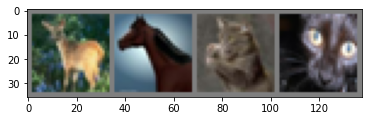

       deer       horse         cat         cat


In [7]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(" ".join("%11s" % classes[labels[j]] for j in range(4)))

### Upload Data

Upload the data to the default AML datastore.

In [8]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir="../data", target_path="data/cifar-10", overwrite=True)

Uploading an estimated of 9 files
Uploading ../data/cifar-10-batches-py/batches.meta
Uploaded ../data/cifar-10-batches-py/batches.meta, 1 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/readme.html
Uploaded ../data/cifar-10-batches-py/readme.html, 2 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/test_batch
Uploaded ../data/cifar-10-batches-py/test_batch, 3 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_1
Uploaded ../data/cifar-10-batches-py/data_batch_1, 4 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_5
Uploaded ../data/cifar-10-batches-py/data_batch_5, 5 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_2
Uploaded ../data/cifar-10-batches-py/data_batch_2, 6 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_3
Uploaded ../data/cifar-10-batches-py/data_batch_3, 7 files out of an estima

$AZUREML_DATAREFERENCE_0147b879f87d480c8a5df17bf2931777

### Create and Register AML Dataset

In [9]:
# Create a dataset object from datastore location
dataset = Dataset.File.from_files(path=(datastore, "data/cifar-10"))

# Register the dataset
dataset = dataset.register(workspace=ws,
                           name="cifar-10-dataset",
                           description="cifar-10 training dataset",
                           create_new_version=True)

# Compute Target

Create a remote compute target to run the experiment on. The below code will first check whether a compute target with name `cpu_cluster_name` already exists and if it does it will use that.

In [10]:
# Choose a name for the CPU cluster
cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", # CPU
                                                           # vm_size='STANDARD_NC6', # GPU
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown=2400)
    
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

# Use get_status() to get a detailed status for the current cluster
print(compute_target.get_status().serialize())

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-01-11T13:05:20.002000+00:00', 'errors': None, 'creationTime': '2021-01-09T21:18:32.620744+00:00', 'modifiedTime': '2021-01-09T21:18:48.294297+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT2400S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


# Training Artifacts

Now you will need to create your training script. In this tutorial, the training script is already provided for you at `pytorch_train.py`. In practice, you should be able to take any custom training script as is and run it with Azure ML without having to modify your code.

However, if you would like to use Azure ML's [tracking and metrics](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#metrics) capabilities, you will have to add a small amount of Azure ML code inside your training script. 

In [11]:
# Create a folder for the training artifacts
training_folder = os.path.join(os.getcwd(), "../src/training")
os.makedirs(training_folder, exist_ok=True)

A training script is created in the aml_training folder. This folder will contain all artifacts needed for aml remote training and these will be copied to the remote compute at runtime.

In [12]:
%%writefile $training_folder/train.py
import os
import argparse
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Run
from model import Net


run = Run.get_context()

if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_path", type=str, help="Path to the training data")
    parser.add_argument("--learning_rate", type=float, default=0.01, help="Learning rate for SGD")
    parser.add_argument("--momentum", type=float, default=0.9,help="Momentum for SGD")

    args = parser.parse_args()

    print("")
    print("========== DATA ==========")
    print("Data Location: " + args.data_path)
    print("Available Files:", os.listdir(args.data_path))
    print("==========================")
    print("")

    # Create dataloader for CIFAR-10 training data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR10(root=args.data_path, train=True, 
                                            download=False, transform=transform)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)

    # Leverage GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Define convolutional network
    net = Net()
    net.to(device)

    # Set up pytorch cross entropy loss and SGD optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=args.momentum)

    print("===== MODEL TRAINING =====")
    
    # Train the network
    for epoch in range(2):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Unpack the data
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Run forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                loss = running_loss / 2000
                run.log("loss", loss) # log loss metric to AML
                print(f"epoch={epoch + 1}, batch={i + 1:5}: loss {loss:.2f}")
                running_loss = 0.0

    print("Finished training")
    print("==========================")
    print("")
    
    os.makedirs("outputs", exist_ok=True)
    file_path = "outputs/cifar_net.pt"
    torch.save(net.state_dict(), file_path) # Anything written to the outputs folder on remote compute is automatically uploaded to the run outputs 
    # run.upload_file(name=file_path, path_or_stream=file_path)
    
    print("Saved and uploaded model")

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/sbirk-aml-ci-low-config/code/Users/s.birk/pytorch-use-cases-azure-ml/template_project/notebooks/../src/training/train.py


Create a model file which contains the network architecture.

In [13]:
%%writefile $training_folder/model.py
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/sbirk-aml-ci-low-config/code/Users/s.birk/pytorch-use-cases-azure-ml/template_project/notebooks/../src/training/model.py


Run the training script locally for debugging.

In [14]:
!python ../src/training/train.py --data_path ../data --learning_rate 0.003 --momentum 0.9

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run:St

# Development Environment

In [20]:
%%writefile ../environments/conda/environment.yml

name: pytorch-aml-env
dependencies:
- python=3.7.1
- pytorch::pytorch=1.7.0
- pytorch::torchvision=0.8.1
- pip:
    - azureml-defaults
    - azureml-sdk
    - azureml-widgets
channels:
- pytorch

Overwriting ../environments/conda/environment.yml


A yml file with conda environment specification is provided in `../environments/conda`. By instantiating an environment object, this conda environment can be used for the remote training run. Alternatively, AML curated environments can also be used. AML curated environments cover common ML scenarios and are backed by cached Docker images. Cached Docker images make the first remote run preparation faster.

In [21]:
# # Display AML Curated Environments
# envs = Environment.list(workspace=ws)

# for env in envs:
#     if env.startswith("AzureML"):
#         print("Name", env)
#         print("packages", envs[env].python.conda_dependencies.serialize_to_string())

In [22]:
# # List workspace environments
# for name, env in ws.environments.items():
#     print(f"Name {name} \t version {env.version}")

# # Retrieve an environment
# env = Environment.get(workspace=ws, name="AzureML-PyTorch-1.3-CPU", version="1")

# # Get base image of retrieved environment
# print(env.docker.base_image)

# print("\n Attributes of retrieved environment:")
# env

On the first run in a given environment, Azure ML spends some time building the environment. On the subsequent runs, Azure ML keeps track of changes and uses the existing environment, resulting in faster run completion.

In [39]:
env = Environment.from_conda_specification(name="pytorch-aml-env",
                                           file_path="../environments/conda/environment.yml")

# Attribute docker.enabled controls whether to use Docker container or host OS for execution.
# This is only relevant for local execution as execution on AML Compute Cluster will always use Docker container.
# env.docker.enabled = True

# Use Python dependencies from your Docker image (as opposed to from conda specification)
# env.python.user_managed_dependencies=True

## Only uncomment one of the three below options
# OPTION 1: Use mcr base image
#env.docker.base_image = "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1"
#env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04' # GPU base image

# Option 2: Use custom base image from workspace-native ACR
#env.docker.base_image = "eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io/base/pytorch"

# OPTION 3: Use custom base image from standalone ACR and use admin user credentials. For this you need to enable admin user in the ACR.
#env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
#env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
#env.docker.base_image_registry.username = "sbirkacr"
#env.docker.base_image_registry.password = "HqAu5Y2We0gZ42IunR5MBXkKc+shf2uj" # replace with Key Vault

# Option 4: Use custom base image from standalone ACR and use service principal authentication. 
#           The service principal needs the AcrPull permission on the standalone ACR.
keyvault = ws.get_default_keyvault()
env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
env.docker.base_image_registry.username = keyvault.get_secret(name="sbirk-acr-sp-username")
env.docker.base_image_registry.password = keyvault.get_secret(name="sbirk-acr-sp-password")

# Option 5: Use custom base image from standalone ACR with anonymous access preview feature.
# env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"

# Create an environment variable.
# This can be retrieved in the training script with os.environ.get("MESSAGE").
# env.environment_variables = {"MESSAGE": "Hello from Azure Machine Learning"}

env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "sbirkacr.azurecr.io/base/pytorch",
        "baseImageRegistry": {
            "address": "sbirkacr.azurecr.io",
            "password": "AzureMlSecret=Env_6fcaf5e93072233a74a9029bc46b9053f295a40aad026a7b040a96b945c549f5_8#EnvironmentDefinition#ContainerRegistry#Password",
            "registryIdentity": null,
            "username": "~hZh.GOOR~x_X2c-4UZ~u8~~0v0Xg5h7D7"
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "pytorch-aml-env",
    "python": {
 

In [40]:
keyvault.get_secret(name="sbirk-acr-sp-username")

'dc0a4a08-8c02-466f-85f9-fa3bab3e9444'

In [41]:
keyvault.get_secret(name="sbirk-acr-sp-password")

'~hZh.GOOR~x_X2c-4UZ~u8~~0v0Xg5h7D7'

# Experiment & Run Configuration

Now that the training artifacts are prepared, a model can be trained on the remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time. 

### Option 1: "Normal" Script Run

In [42]:
# Create the experiment
experiment = Experiment(workspace=ws, 
                        name="cifar-image-classification-pytorch")

# Create the script run configuration
config = ScriptRunConfig(source_directory="../src/training",
                         script="train.py",
                         compute_target=compute_target,
                         arguments=[
                             "--data_path", dataset.as_named_input("input").as_mount(),
                             "--learning_rate", 0.003,
                             "--momentum", 0.92])

config.run_config.environment = env

# Submit the run
run = experiment.submit(config)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Option 2: Hyperdrive Run

In [26]:
# PLACEHOLDER

In [27]:
# Get portal URL
run.get_portal_url()

'https://ml.azure.com/experiments/cifar-image-classification-pytorch/runs/cifar-image-classification-pytorch_1610372555_27b6180c?wsid=/subscriptions/bf088f59-f015-4332-bd36-54b988be7c90/resourcegroups/sbirk-aml-rg/workspaces/sbirk-aml-ws'

In [28]:
run.wait_for_completion(show_output=False)

{'runId': 'cifar-image-classification-pytorch_1610372555_27b6180c',
 'target': 'cpu-cluster',
 'status': 'Finalizing',
 'startTimeUtc': '2021-01-11T13:45:30.770926Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '97652fa3-3b5e-4bba-ac4d-c95865606e8e',
  'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'azureml.git.branch': 'dev',
  'mlflow.source.git.branch': 'dev',
  'azureml.git.commit': '683fb60102825f5cbbbad514b260aaab9c6889ec',
  'mlflow.source.git.commit': '683fb60102825f5cbbbad514b260aaab9c6889ec',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'b392cc2b-166d-4d90-a004-63716d19f8ab'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input', 'mechanism':

In [29]:
# Check run metrics, details and file names
print(run.get_metrics())
print(run.get_details())
print(run.get_file_names())

{'loss': [2.0419990037679674, 1.747695811420679, 1.6692877805307507, 1.6215058232545854, 1.593336064208299, 1.5800246047973632, 1.511356056600809, 1.4856634497791528, 1.5171218004077673, 1.5023110489994287, 1.4865605378374458, 1.5088471974283457]}
{'runId': 'cifar-image-classification-pytorch_1610372555_27b6180c', 'target': 'cpu-cluster', 'status': 'Finalizing', 'startTimeUtc': '2021-01-11T13:45:30.770926Z', 'properties': {'_azureml.ComputeTargetType': 'amlcompute', 'ContentSnapshotId': '97652fa3-3b5e-4bba-ac4d-c95865606e8e', 'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git', 'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git', 'azureml.git.branch': 'dev', 'mlflow.source.git.branch': 'dev', 'azureml.git.commit': '683fb60102825f5cbbbad514b260aaab9c6889ec', 'mlflow.source.git.commit': '683fb60102825f5cbbbad514b260aaab9c6889ec', 'azureml.git.dirty': 'False', 'ProcessInfoFile': 'azureml-logs/process_in

# Model Registration

In [31]:
model_path = "outputs/cifar_net.pt"

model = run.register_model(model_name="cifar10-model",
                           model_path=model_path,
                           model_framework=Model.Framework.PYTORCH,
                           description="cifar10 model")

print(model.name, model.id, model.version, sep="\t")

cifar10-model	cifar10-model:9	9


In [34]:
# Download the model
run.download_file(name=model_path, output_file_path="../outputs/cifar_net.pt")

# Resource Clean Up

In [ ]:
# compute_target.delete()